# 1. 라이브러리 불러오기

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

import pandas as pd
import random
import os
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

import xgboost as xgb
import random

In [ ]:
import jinja2
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings(action='ignore')

from pycaret.classification import * 

# 2. 데이터 불러오기

In [ ]:
train = pd.read_excel('./dataset_1018.xlsx',engine ='openpyxl')

# 정형 데이터에서 환자 번호와 같은 인자는 필수로 지워야함!!! 
train = train.drop('number', axis=1)
train.head()

# 3. 결측치 확인하기

In [ ]:
def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

missing_col = check_missing_col(train)

# missing_col_test = check_missing_col(test)


# 4. 결측치 제거하기

In [ ]:
# 결측치를 처리하는 함수를 작성합니다.
def handle_na(data, missing_col):
    temp = data.copy()
    for col, dtype in missing_col:
        if dtype == 'O':
            # 범주형 feature가 결측치인 경우 해당 행들을 삭제해 주었습니다.
            temp = temp.dropna(subset=[col])
    return temp

train = handle_na(train, missing_col)

# 결측치 처리가 잘 되었는지 확인해 줍니다.
missing_col = check_missing_col(train) 

# 5. 필요없는 인자들 제거하기

In [ ]:
from sklearn.model_selection import train_test_split

train = train.drop(['Mortality', 'Q1', 'Q5', 'D1','D2','D3','EGD'], axis = 1).copy() #필요없는 id열 삭제
train = train.drop('Intracranial hemorrhage', axis = 1).copy() #필요없는 id열 삭제
train = train.drop('Transfusion', axis = 1).copy() #필요없는 id열 삭제

# 6. Train/ Valid 분리하기

In [ ]:
#### test폴더 따로 있으면 사용
#train_data, val_data = train_test_split(data, test_size=0.5)
# train_data = data
# val_data = test
# train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
# val_data.reset_index(inplace=True)


#### default
# 해당 코드는 받은 데이터가 1 = True, 2 = False라서 0 = False, 1 = True로 수정해주는 코드
# 반대로하면 AUC score가 이상하게 나옴.
train.GIB = train.GIB.replace({1:1, 2:0})

train_dataset, test_dataset = train_test_split(train, test_size=0.3,shuffle=True,random_state=15)
train_data = train_dataset
test_data = test_dataset

train_data.reset_index(inplace=True) #전처리 과정에서 데이터가 뒤섞이지 않도록 인덱스를 초기화
test_data.reset_index(inplace=True)

train_data = train_data.drop('index', axis = 1).copy() #필요없는 id열 삭제
test_data = test_data.drop('index', axis = 1).copy() #필요없는 id열 삭제

In [ ]:
print( 'train 데이터 셋 모양 :', train_data.shape)
print( 'test 데이터 셋 모양 :', test_data.shape)

print(train_data.GIB.value_counts(), test_data.GIB.value_counts())

# Pycaret 시작!!

In [ ]:
# 자동으로 데이터를 전처리(인자 생성 및 정규화)
# 그리고 Pycaret을 돌리기 위해서 무조건 setup에 데이터를 넣어줘야한다.
clf = setup(data = train_data, target = 'GIB',normalize = True ,session_id=123,silent=True,use_gpu = False )

In [ ]:
# 간단하게 여러 모델을 돌리고 성능을 보여줌.
# 해당 부분을 보면서 모델 선정 가능!
compare_models(sort = 'AUC')

### 모델 생성하기

In [ ]:
# 모델 생성하기
ada = create_model('et', cross_validation = False)

In [ ]:
gbc = create_model('gbc', cross_validation = False)

In [ ]:
lr = create_model('lr', cross_validation = False)

### 하이퍼파라미터 튜닝

n_iter는 얼마나 많이 튜닝을 진행할지에 대한 파라미터

In [ ]:
# 하이퍼파라미터 튜닝
tuned_ada = tune_model(ada,optimize='AUC', n_iter = 200)

In [ ]:
tuned_gbc = tune_model(gbc,optimize='AUC', n_iter = 200)

In [ ]:
tuned_lr = tune_model(lr,optimize='AUC', n_iter = 200)

### 모델 앙상블

bledn_models는 튜닝한 모델을 불러와서 앙상블을 진행한다.

finalize_model은 validation으로 사용한 데이터까지 학습을 해준다.

In [ ]:
blender_specific = blend_models(estimator_list = [tuned_gbc,tuned_ada,tuned_lr], optimize = 'AUC')

final_model = finalize_model(blender_specific)

### 예측하기

In [ ]:
pred = predict_model(final_model, data = test_data)

### Feature importance 

In [ ]:
plt.figure(figsize = (200,9))
plot_model(estimator =tuned_gbc, plot = 'feature')
plt.show()


# AutoML 시작!!

In [ ]:
#### 1. h2o 분석 준비하기 ####
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
%matplotlib inline
h2o.init( min_mem_size= 16,max_mem_size = 16)
h2o.no_progress()
# H2O 클러스터 가동 시간, 시간대, 버전, 버전 수명, 클러스터 이름, 할당 된 하드웨어 리소스 (노드 수, 메모리, 코어 수), 연결 URL, 노출 된 H2O API 확장 및 사용 된 파이썬 버전과 같은 추가 정보가 출력

### Train/ Valid 설정

In [ ]:
# data_df을 8:2로 나눈다. 
train, valid = train_test_split(train_data,
                                test_size=0.2, 
                                shuffle=True)


### 학습 시간 설정하기

max_runtime_secs는 초 단위로 60 * 60 * 12하면 총 12시간.

In [ ]:
max_runtime_secs = 60*60*12

In [ ]:
len(train_dataset), len(train),len(valid),len(test_dataset)

### 학습하기

학습 코드에서 max_runtime_secs는 위에 있는 파라미터로 랜덤 서치를 몇 시간 동안 진행할지에 대한 파라미터
exclude_algos는 어떤 알고리즘을 제외하고 서치할지에 대한 파라미터


https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html

In [ ]:
%%time
################################################################
## make dataset
# Identify the response and set of predictors

# 정답 인자 이름 넣어주기
y = "GIB"
x = list(train.columns)  #if x is defined as all columns except the response, then x is not required
x.remove(y)

# h2o에 맞는 파일형(??)으로 변환. 
# 우리가 데이터를 cuda로 보내주는 작업이랑 동일.
h2o_train = h2o.H2OFrame(train)
h2o_valid = h2o.H2OFrame(valid)

# For binary classification, response should be a factor
h2o_train[y] = h2o_train[y].asfactor()
h2o_valid[y] = h2o_valid[y].asfactor()

################################################################    
######################학습 코드#################################
################################################################    
## Run AutoML for 120 seconds
aml = H2OAutoML(max_runtime_secs=max_runtime_secs, exclude_algos =['DRF','GLM','StackedEnsemble'])
# aml = H2OAutoML(max_runtime_secs=max_runtime_secs,max_runtime_secs_per_model = int(max_runtime_secs/10), seed=1)
aml.train(x = x, y = y, training_frame=h2o_train, leaderboard_frame=h2o_valid)
################################################################
## save metric

# Print Leaderboard (ranked by xval metrics)
leaderboard = aml.leaderboard
performance = aml.leader.model_performance(h2o_valid)  # (Optional) Evaluate performance on a test set

model_id   =aml.leader.model_id  # 최고 모델 명
accuracy   =performance.accuracy()  # 정확도
precision  =performance.precision()  # precision
recall     =performance.recall()  # recall
F1         =performance.F1()  # f1
auc        =performance.auc()  # auc
variable_importance=aml.leader.varimp()  # 중요한 입력 변수

print(model_id, accuracy, precision, recall, F1, auc, variable_importance)

### Validation 기준으로 결과 확인하기 

MSE, AUC등 여러 스코어를 확인할 수 있다.

In [ ]:
print(performance)

### Feature importance

In [ ]:
## 중요 변수 시각화
aml.leader.varimp_plot()

## automl 결과 확인
# Get AutoML object by `project_name`
get_aml = h2o.automl.get_automl(aml.project_name)
# Predict with top model from AutoML Leaderboard on a H2OFrame called 'test'
label_predicted = get_aml.predict(h2o_valid)
print(label_predicted['predict'])
print(h2o_valid['GIB'])

###  Test 셋 결과 확인하기

In [ ]:
h2o_test = h2o.H2OFrame(test_data)

# For binary classification, response should be a factor
# h2o_test[y] = h2o_test[y].asfactor()

# Predict with top model from AutoML Leaderboard on a H2OFrame called 'test'
label_predicted = get_aml.predict(h2o_test)
# print(label_predicted['predict'])
# print(h2o_valid['nerdiness'])

In [ ]:
performance = aml.leader.model_performance(h2o_test)
performance

In [ ]:
len(label_predicted)

# Mljar 시작!!


Mljar에서는 mode라는 파라미터가 있으며 explain, perform, compete, optuna로 설정이 가능하며 optuna가 가장 무겁다.

#### optuna는 기본적으로 k-fold를 10번을 진행하여 데이터 불균형이 심하면 약간 조정을 해야한다.
#### --> 특정 fold에 음성(False)만 있는 경우가 존재
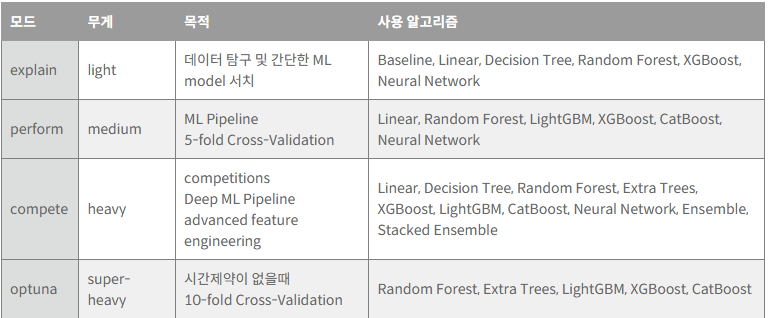

total_time_limit은 h2o의 "max_runtime_secs"와 동일하게 학습 시간을 설정하는 파라미터

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight


automl = AutoML(mode="Optuna", ml_task="binary_classification"
    , eval_metric='auc',
    total_time_limit = 14*3600,
    stack_models = 'auto',
    random_state=42, results_path="optuna")

X_train = train.drop('GIB',axis=1)
y_train = train['GIB'].astype("int64")

# weights = compute_sample_weight(class_weight="balanced", y=y_train)

automl.fit(X_train, y_train)

### 학습이 끝나면 그림과 같이 폴더 및 결과 생성
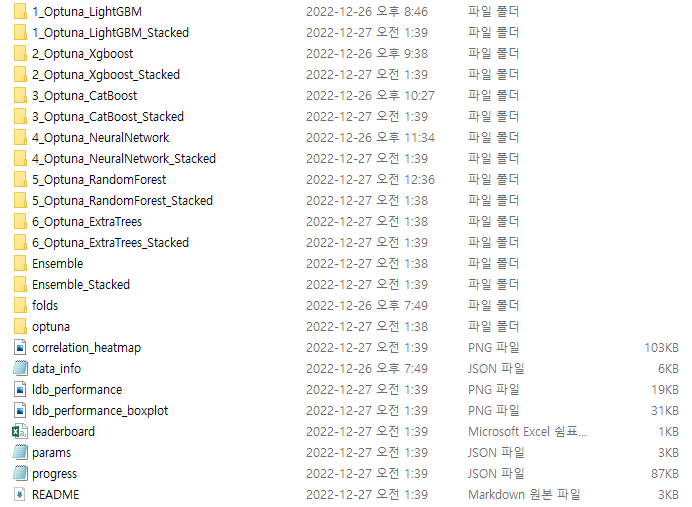

### Test 셋 결과 확인하기

In [ ]:
X_exter = exter_valid.drop('GIB',axis=1)
y_exter = exter_valid['GIB'].astype("int64")

y_pred_prob = automl.predict_proba(X_exter)
print(f"AUROC: {roc_auc_score(y_exter, automl.predict(X_exter)):.2f}%")